In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook

In [2]:
# Let's generate 1000 events drawn from a Gaussian distribution and calculate the mean and std dev

npts = 1000
mu = 10.0
sigma = 1.0

data = np.random.normal(mu,sigma,npts)

print "calculated mean   : %f" % (np.mean(data))
print "calculated std dev: %f" % (np.std(data))


calculated mean   : 10.010270
calculated std dev: 1.000560


<IPython.core.display.Javascript object>


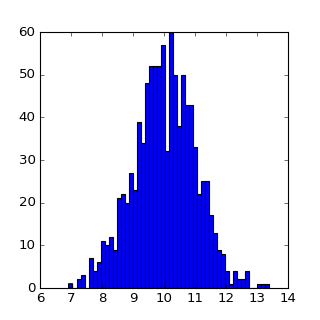

In [3]:
plt.figure(figsize=(4,4))
plt.hist(data,bins=50);

In [4]:
# Now, generate a "fake" dataset of 1000 points randomly drawn from data. 
# Because you are pulling out 1000 points (the same number as in data), you will have some
# repeating data points. That's OK!

fake_data=np.random.choice(data,1000)
# When you make this fake dataset, calculate the mean

print np.mean(fake_data)
# YOUR CODE HERE

10.0540916066


<IPython.core.display.Javascript object>


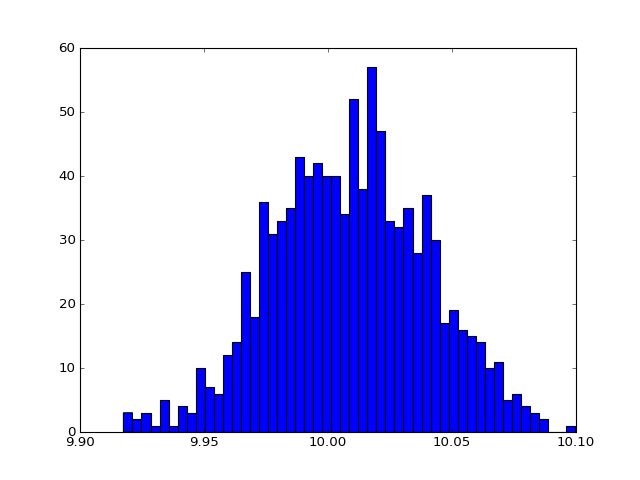

average mean:  10.0086941705
avergae standard deviation: 0.998944582397


In [5]:
# Now do this 1000 times, and keep track of all the different means from these mock datasets. 
# Histogram those means. 
plt.figure()
means=[]
stds=[]
for x in range(1000):
    fake_data=np.random.choice(data,1000)
    stds.append(np.std(fake_data))
    means.append(np.mean(fake_data))
plt.hist(means, bins=50)
print 'average mean: ', np.mean(means)
print 'avergae standard deviation:', np.mean(stds)
# YOUR CODE HERE

In [7]:
# What is the mean of those distributions?

# What are the values around the mean that enclose 68% of these mock data means? 95%?
'''
diff= abs(np.mean(stds)-stds)
diff.sort()
diff[int(1000*.68)]
print np.mean(stds)-diff[int(1000*.68)]
print np.mean(stds)+diff[int(1000*.68)]
'''
diff1= np.mean(stds)-stds
diff1.sort()
print diff1[(int(1000*.34)-1)]+np.mean(stds)
#print diff1
print diff1[(int(1000*.84)-1)] +np.mean(stds)
print 'mean of stds:',np.mean(stds)
print 'std of stds',np.std(stds)



0.989444976785
1.02155057953
mean of stds: 0.998944582397
std of stds 0.022311566749
